In [1]:
# Importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

Only around 27% of the customers in the dataset have churned.
This means that we are dealing with an imbalanced classification problem.
We will need to perform some feature engineering to create a balanced training dataset before building the predictive model.

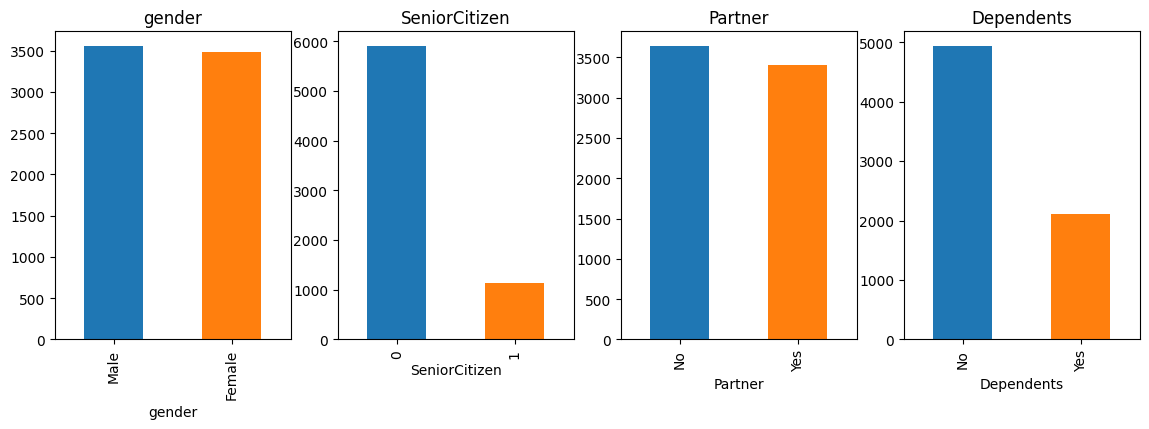

In [4]:
# EDA for Customer Churn Prediction.
cols = ["gender","SeniorCitizen","Partner","Dependents"]
numerical = cols
plt.figure(figsize = (14,4))
for i , col in enumerate(numerical):
    ax = plt.subplot(1,len(numerical),i+1)
    df[str(col)].value_counts().plot(kind = "bar",color=['C0','C1'])
    ax.set_title(f"{col}")

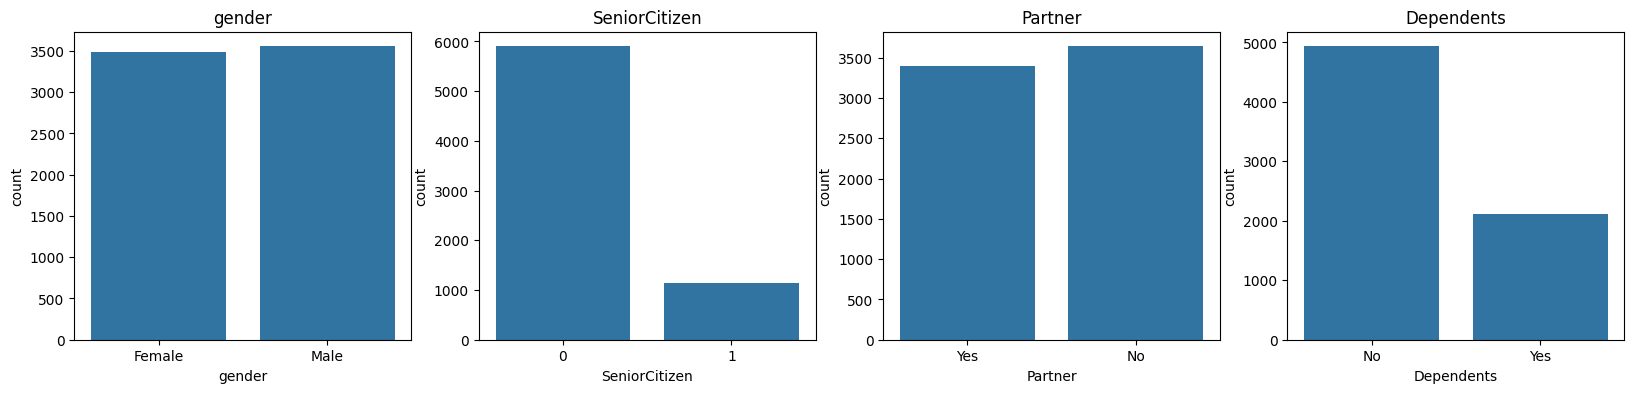

In [5]:
cols = ["gender","SeniorCitizen","Partner","Dependents"]
numerical = cols
plt.figure(figsize = (20,4))
for i , col in enumerate(numerical):
    ax = plt.subplot(1,len(numerical),i+1)
    sns.countplot(x=str(col),data = df)
    ax.set_title(f"{col}")

Most customers in the dataset are younger individuals without a dependent. There is an equal distribution of user gender and marital status.

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

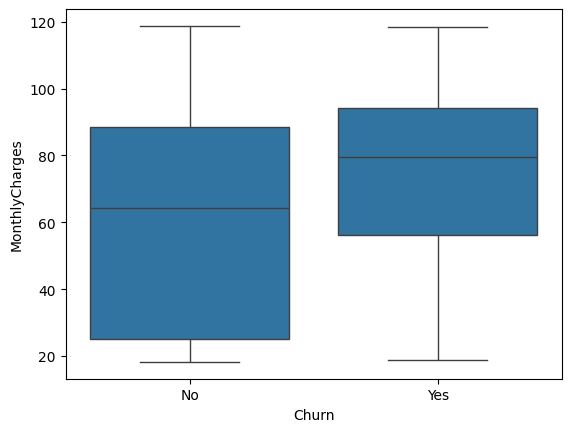

In [6]:
sns.boxplot(x = "Churn" , y = "MonthlyCharges", data = df)

The assumption above is true. Customers who churned have a higher median monthly charge than customers who renewed their subscription.

In [7]:
cols = ['InternetService',"TechSupport","OnlineBackup","Contract"]

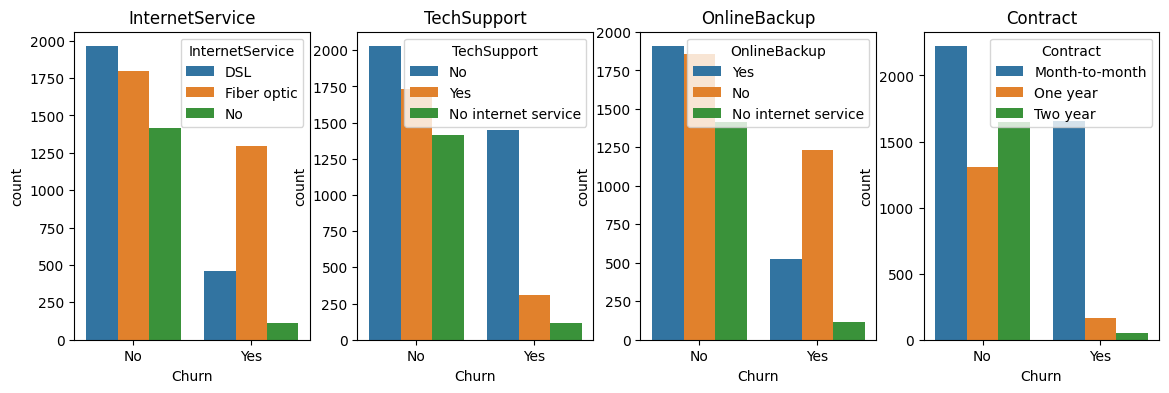

In [8]:
plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="Churn", hue = str(col), data = df)
    ax.set_title(f"{col}")

InternetService: It is clear from the visual above that customers who use fiber optic Internet churn more often than other users. This might be because fiber Internet is a more expensive service, or this provider doesn’t have good coverage.

TechSupport: Many users who churned did not sign up for tech support. This might mean that these customers did not receive any guidance on fixing technical issues and decided to stop using the service.

OnlineBackup: Many customers who had churned did not sign up for an online backup service for data storage.

Contract: Users who churned were almost always on a monthly contract. This makes sense, since these customers pay for the service on a monthly basis and can easily cancel their subscription before the next payment cycle.

In [43]:
# Preprocessing data for Customer Churn
# 1) Cleaning the data.
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

In [44]:
# 2) Encoding Categorical variables.
cat_features = df.drop(['customerID','TotalCharges','MonthlyCharges','SeniorCitizen','tenure'],axis=1)


In [12]:
cat_features.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [13]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df_cat = cat_features.apply(le.fit_transform)
df_cat.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


In [14]:
num_features = df[['customerID','TotalCharges','MonthlyCharges','SeniorCitizen','tenure']]
finaldf = pd.merge(num_features, df_cat, left_index=True, right_index=True)

In [15]:

from sklearn.model_selection import train_test_split

finaldf = finaldf.dropna()
finaldf = finaldf.drop(['customerID'],axis=1)

In [17]:
X = finaldf.drop(['Churn'],axis=1)
y = finaldf['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Oversampling the training dataset because the dataset is imbalanced, which means that a majority of values in the target variable belong to a single class. Most customers in the dataset did not churn - only 27% of them did.

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
oversample = SMOTE(k_neighbors=5)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)
X_train, y_train = X_smote, y_smote

In [20]:
y_train.value_counts()

Churn
0    3452
1    3452
Name: count, dtype: int64

There should be 3,452 values in each class, which means that the training dataset is now balanced.

**Building the Customer Churn Prediction Model**

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=46)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=46)

In [22]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf,X_train,y_train,cv=5)
print(scores)

[0.73642288 0.77769732 0.89065894 0.89717596 0.89855072]


In [23]:
from sklearn.metrics import accuracy_score

preds = rf.predict(X_test)
print(accuracy_score(preds,y_test))

0.7733735458853942


**Customer Churn Using Tensorflow -  ANN**

In [24]:
import tensorflow as tf

In [25]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU,ELU,LeakyReLU,PReLU
from tensorflow.keras.layers import Dropout

In [26]:
# Initializing the ANN
classifier=Sequential()

In [27]:
# Adding input layer
classifier.add(Dense(units=11,activation = "PReLU"))
classifier.add(Dropout(0.3))

In [28]:
classifier.add(Dense(units=7,activation="PReLU"))# Adding the first layer


In [29]:
# Adding the second layer
classifier.add(Dense(units=6,activation="PReLU"))

In [30]:

# Adding the output layer
classifier.add(Dense(units=1,activation="sigmoid"))

In [34]:
import tensorflow

In [36]:
opt=tensorflow.keras.optimizers.Adam(learning_rate=0.001)
classifier.compile(optimizer=opt,loss="binary_crossentropy",metrics=["accuracy"])

In [37]:
# Applying the early stopping .
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0.0001,patience=20,verbose=1,mode="auto",restore_best_weights=False)

model_history=classifier.fit(X_train,y_train,validation_split=0.33,batch_size=10,epochs=1000,callbacks=early_stopping)
print(model_history)

Epoch 1/1000
463/463 [==============================] - 6s 4ms/step - loss: 39.4091 - accuracy: 0.6112 - val_loss: 3.5670 - val_accuracy: 0.0250
Epoch 2/1000
463/463 [==============================] - 1s 3ms/step - loss: 1.6499 - accuracy: 0.6856 - val_loss: 0.8467 - val_accuracy: 0.6415
Epoch 3/1000
463/463 [==============================] - 1s 3ms/step - loss: 0.9128 - accuracy: 0.6835 - val_loss: 0.9549 - val_accuracy: 0.5055
Epoch 4/1000
463/463 [==============================] - 1s 3ms/step - loss: 0.8085 - accuracy: 0.7135 - val_loss: 1.3326 - val_accuracy: 0.2286
Epoch 5/1000
463/463 [==============================] - 1s 3ms/step - loss: 0.9203 - accuracy: 0.7018 - val_loss: 1.0474 - val_accuracy: 0.3260
Epoch 6/1000
463/463 [==============================] - 1s 3ms/step - loss: 0.8393 - accuracy: 0.7077 - val_loss: 1.7633 - val_accuracy: 0.2089
Epoch 7/1000
463/463 [==============================] - 2s 4ms/step - loss: 0.7055 - accuracy: 0.7295 - val_loss: 0.8103 - val_accuracy

In [38]:
# Summarize the history for accuracy
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

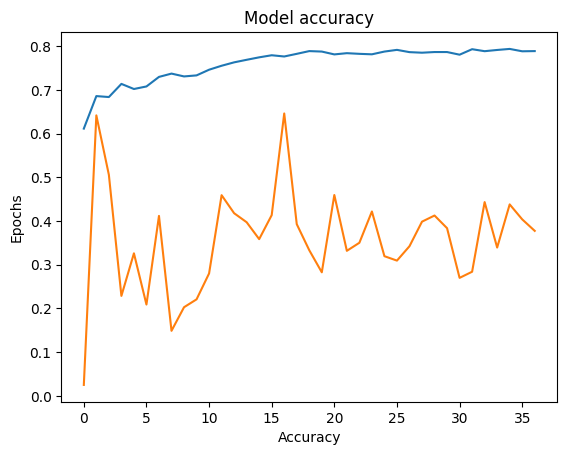

In [39]:

plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.show()

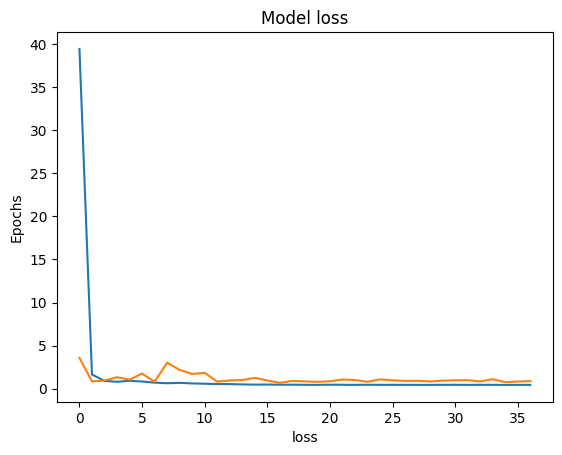

In [40]:
plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("loss")
plt.ylabel("Epochs")
plt.show()

In [41]:
# Making  the predictions and evaluating the model
y_pred=classifier.predict(X_test)
y_pred=(y_pred >= 0.5)

73/73 [==============================] - 1s 7ms/step


In [42]:
from sklearn.metrics import confusion_matrix,accuracy_score

cm=confusion_matrix(y_test,y_pred)
print(cm)

score=accuracy_score(y_test,y_pred)
print(score)

[[1624   87]
 [ 398  212]]
0.7910383455407152


While using Random forest classifier the accuraacy was 77%. After appyling PReLU the accuracy has incresed 79%.